# MidiNetデモ

- サンプルの生成
- サンプルのオーディオ化
- サンプルの可視化，読込，再生

In [1]:
import os, glob, ipdb, platform, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer, create_audio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
learning_dir = f"{base_dir}/learning"

## サンプルの生成

サンプル生成用のGにはbatch_normがない

In [3]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

class SampleGenerator(nn.Module):
    def __init__(self, pitch_range=128):
        super(SampleGenerator, self).__init__()
        self.gf_dim  = 64
        self.y_dim   = 13

        self.h1      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h3      = nn.ConvTranspose2d(in_channels=157, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=157, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))

        self.linear1 = nn.Linear(113,1024)
        self.linear2 = nn.Linear(1037,self.gf_dim*2*2*1)

    def forward(self, z, prev_x, y, batch_size):
        h0_prev = lrelu(self.h0_prev(prev_x))
        h1_prev = lrelu(self.h1_prev(h0_prev))
        h2_prev = lrelu(self.h2_prev(h1_prev))
        h3_prev = lrelu(self.h3_prev(h2_prev))

        yb = y.view(batch_size, self.y_dim, 1, 1)

        z = torch.cat((z,y),1)

        h0 = F.relu(self.linear1(z))
        h0 = torch.cat((h0,y),1)

        h1 = F.relu(self.linear2(h0))
        h1 = h1.view(batch_size, self.gf_dim * 2, 2, 1)
        h1 = concat_vector(h1, yb)
        h1 = concat_vector(h1, h3_prev)

        h2 = F.relu(self.h1(h1))
        h2 = concat_vector(h2, yb)
        h2 = concat_vector(h2, h2_prev)

        h3 = F.relu(self.h2(h2))
        h3 = concat_vector(h3, yb)
        h3 = concat_vector(h3, h1_prev)

        h4 = F.relu(self.h3(h3))
        h4 = concat_vector(h4, yb)
        h4 = concat_vector(h4, h0_prev)

        g_x = torch.sigmoid(self.h4(h4))

        return g_x

In [4]:
def get_model(version, pitch_range=128, device="cpu"):
    model_paths = glob.glob(os.path.join(learning_dir, version, "netG_epoch=*"))
    if len(model_paths) > 1:
        print(f"{len(model_paths)} models found in {os.path.join(learning_dir, version)}")
        for i, path in enumerate(model_paths):
            print(f"{i}: {path.split('/')[-1]}")
        model_path = model_paths[int(input("input the number of model"))]
    else:
        model_path = model_paths[0]
    print(f"model is loaded from {model_path.split('/')[-1]}")

    sampleG = SampleGenerator(pitch_range=pitch_range)
    
    if not isinstance(device, torch.device):
        device = torch.device(device)
    
    sampleG.load_state_dict(torch.load(model_path, map_location=device))
    return sampleG

sharp_keys = np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
flat_keys = np.array(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'])

def get_chord_vectors(chord_str):
    chords = chord_str.split(" ")
    chord_vecs = torch.zeros([len(chords), 13])
    for i, chord in enumerate(chords):
        if '#' in chord:
            key = np.where(sharp_keys == chord[:2])[0]
        elif 'b' in chord:
            key = np.where(flat_keys == chord[:2])[0]
        else:
            key = np.where(sharp_keys == chord[0])[0]
        chord_vecs[i, key] = 1
        chord_vecs[i, -1] = 1 if chord[-1] == 'm' else 0
    return chord_vecs

def chord_to_pianoroll(chord_str, bar_res, octave=3):
    chords = chord_str.split(" ")
    chord_nproll = np.zeros([len(chords)*bar_res, 128])
    origin_pitch = (octave + 1) * 12
    for i, chord in enumerate(chords):
        if '#' in chord:
            key = np.where(sharp_keys == chord[:2])[0]
        elif 'b' in chord:
            key = np.where(flat_keys == chord[:2])[0]
        else:
            key = np.where(sharp_keys == chord[0])[0]
        mode = 3 if chord[-1] == 'm' else 4
        chord_nproll[i*bar_res:(i+1)*bar_res-1, origin_pitch + key] = 1
        chord_nproll[i*bar_res:(i+1)*bar_res-1, origin_pitch + key + mode] = 1
        chord_nproll[i*bar_res:(i+1)*bar_res-1, origin_pitch + key + 7] = 1
    return chord_nproll

def get_melody(melody_list, length):
    melody = torch.zeros([length, 128])
    for i, note in enumerate(melody_list):
        melody[i, note] = 1
    return melody

def monophonize(nproll):
    monophonic = np.zeros_like(nproll)
    for i, p in enumerate(np.argmax(nproll, axis=1)):
        if nproll[i].any():
            monophonic[i, p] = 1
    return monophonic

def create_melody(model, priming_melody_list, chord_str, show_map=False, mono=True, on_note_thresh=0, pitch_range=[0, 128], beat_res=4, beats_in_bar=4, nz=100):
    bar_res = beat_res * beats_in_bar
    
    chords = get_chord_vectors(chord_str)
    n_bars = len(chords)
    
    melody = get_melody(priming_melody_list, n_bars * bar_res)
    
    noise = torch.randn(n_bars, nz)
    
    for bar in range(1, n_bars):
        bar_noise = noise[bar].view(1, nz)
        prev = melody[(bar-1)*bar_res:bar*bar_res].view(1,1,bar_res,128)
        chord = chords[bar].view(1, 13)
        sample_bar = model(bar_noise, prev, chord, 1)
        melody[bar*bar_res:(bar+1)*bar_res] = sample_bar[0][0]
    
    melody = melody.detach().numpy()
    
    bottom, top = pitch_range
    chords = chord_to_pianoroll(chord_str, bar_res)
    
    if show_map:
        fig, ax = plt.subplots(figsize=(21, 7))
        ax.imshow(np.flipud(melody[:, bottom-6:top+6].T))
    
    melody[melody < on_note_thresh] = 0
    
    if mono:
        melody = monophonize(melody)

    melody[:, :bottom], melody[:, top:] = 0, 0
    
    tracks = [Track(item, name=name) for item, name in zip([melody, chords], ['melody', 'chord'])]
    
    downbeat = np.zeros(melody.shape[0], dtype=bool)
    downbeat[::bar_res] = True
    song = Multitrack(tracks=tracks, beat_resolution=beat_res, downbeat=downbeat, name=song_name)
    
    return song

以下で好き勝手曲を作る  
曲の長さはコードの数で決まる  
最初の小節を作成して渡したら，あとはコード進行に合わせて自動的に後ろの小節が生成される

In [5]:
version = "original"
sampleG = get_model(version)

model is loaded from netG_epoch=500_nx=100_l1=10_l2=10_gt=10_rw=0.9.pth


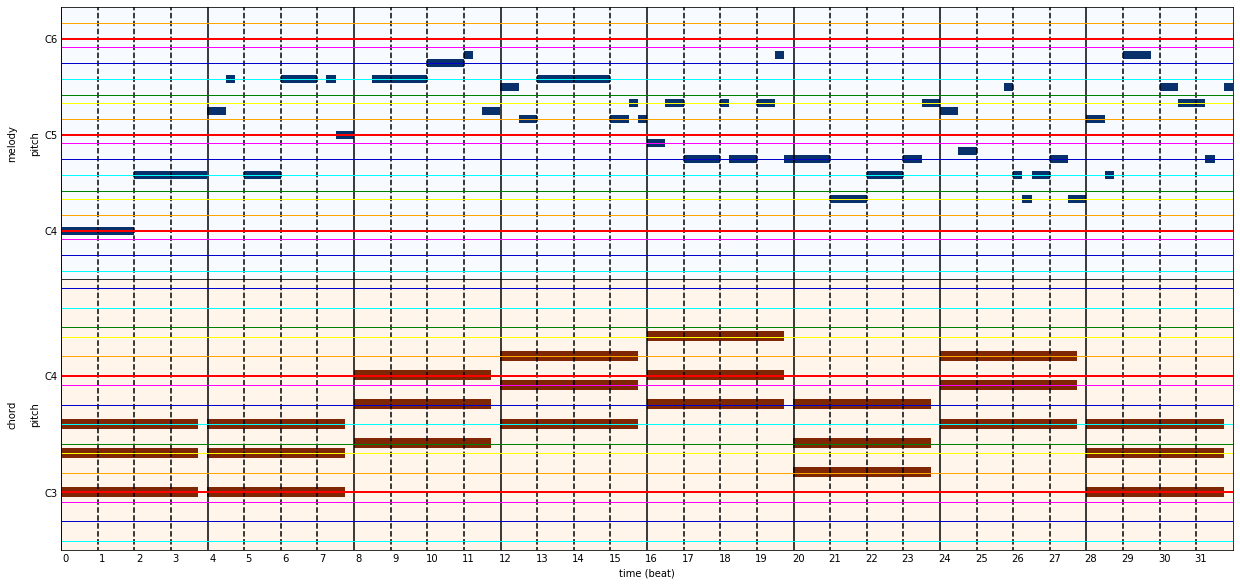

In [14]:
song_name = "sample"

chord_str = "C C F G Am Dm G C"
priming_melody = [60, 60, 60, 60, 60, 60, 60, 60, 67, 67, 67, 67, 67, 67, 67, 67]

song = create_melody(sampleG, priming_melody, chord_str, show_map=False, on_note_thresh=0.1, pitch_range=[60, 83])
grid_plot(song)

## サンプルのオーディオ化

In [15]:
tempo = 120
song.tracks[0].program = 90
song.tracks[1].program = 0
song.tracks[0].assign_constant(100)
song.tracks[1].assign_constant(64)
print("melody instrument:", pretty_midi.program_to_instrument_name(song.tracks[0].program))
print("chord  instrument:", pretty_midi.program_to_instrument_name(song.tracks[1].program))
save_dir = os.path.join(learning_dir, version)
create_audio(song, save_dir, song_name)

melody instrument: Pad 3 (polysynth)
chord  instrument: Acoustic Grand Piano
wave file length: 749700
wave file saved to ../datasets/theorytab/midinet/learning/original/sample.wav
sample.npy saved!
sample.midi file saved!
The wave file is replaced to ../datasets/theorytab/midinet/learning/original/sample.mp3 



## 生成音楽の読み込みと可視化，再生

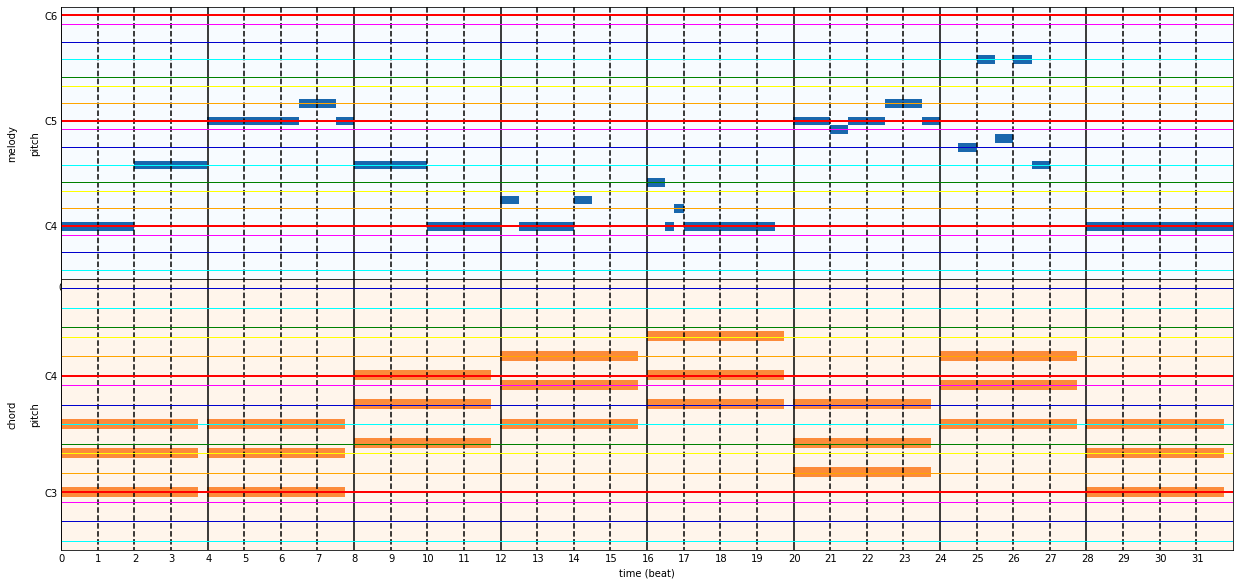

In [15]:
import os
from pypianoroll import Multitrack
from IPython.display import Audio
from utils import grid_plot

# song_name = 'sample'
# version = "natural"
result_dir = "../datasets/theorytab/midinet/learning"

sample_midi_path = os.path.join(result_dir, version, f'{song_name}.midi')
sample_sound_path = os.path.join(result_dir, version, f'{song_name}.mp3')

loaded = Multitrack(sample_midi_path)
grid_plot(loaded)

Audio(sample_sound_path)